In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [79]:
df = pd.read_csv('preprocessed_data.csv', low_memory=False)
df.head()

,Unnamed: 0,url,type,url_len,use_of_ip,domain,count_https,count_http,abnormal_url,@,...,sum_count_special_chars,pri_domain,redirection,hostname_length,tld,tld_length,short_url,count_digits,fd_len,is_sus_words
0,0,br-icloud.com.br,phishing,16,0,com.br,0,0,0,0,...,3,br-icloud.com.br,0,0,NaN,-1,0,0,0,0
1,1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,com,0,0,0,0,...,2,mp3raid.com,0,0,NaN,-1,0,1,5,0
2,2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,org,0,0,0,0,...,2,bopsecrets.org,0,0,NaN,-1,0,1,7,0
3,3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0,be,0,1,1,0,...,9,www.garage-pirenne.be,0,21,be,2,0,7,9,0
4,4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,net,0,1,1,0,...,7,adventure-nicaragua.net,0,23,net,3,0,22,9,0


In [80]:
df['type'].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

### Splitting the data into benign and malicious

In [81]:
benign_data = df[df['type'] == 'benign']
malicious_data = df[df['type'] != 'benign']

In [82]:
df.columns

Index(['Unnamed: 0', 'url', 'type', 'url_len', 'use_of_ip', 'domain',
       'count_https', 'count_http', 'abnormal_url', '@', '?', '-', '=', '.',
       '#', '%', '+', '$', '!', '*', ',', '//', 'sum_count_special_chars',
       'pri_domain', 'redirection', 'hostname_length', 'tld', 'tld_length',
       'short_url', 'count_digits', 'fd_len', 'is_sus_words'],
      dtype='object')

In [83]:
features = ['url_len', 'use_of_ip', 'count_https', 'count_http', 'abnormal_url', '@', '?', 
    '-', '=', '.','#', '%', '+', '$', 'sum_count_special_chars', 'fd_len', 'is_sus_words',
    'redirection', 'short_url', 'count_digits' , 'hostname_length', 'tld_length'
]

In [84]:
print(f"Selecting {len(features)} features from the dataset.")

Selecting 22 features from the dataset.


#### Training data (safe URLs)

In [85]:
X_train = benign_data[features]

In [86]:
from sklearn.preprocessing import MinMaxScaler

In [87]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [88]:
#X_train_scaled[:2]

#### Testing data(malicious URLs)

In [73]:
# Combine benign and malicious data for testing
#test_data = pd.concat([benign_data, malicious_data])
#X_test = test_data[features]
#X_test_scaled = scaler.transform(X_test)
#y_test = test_data['type'].apply(lambda x: 1 if x != 'benign' else 0)

In [89]:
X_test = malicious_data[features]
y_test = malicious_data['type'].apply(lambda x: 1 if x != 'benign' else 0)  # Binary labels for malicious URLs

In [91]:
X_test_scaled = scaler.transform(X_test)

In [73]:
#y_test_full = df['type'] 

In [74]:
#df_features = df.drop(columns=['type'])

In [75]:
#X_full = df_features[features]

In [34]:
input_dim = X_train_scaled.shape[1]

#Input Layer
input_layer = Input(shape=(input_dim,))

#Encoder(Compression)
encoder = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)  # Compressing step
encoder = Dropout(0.3)(encoder)
encoder = BatchNormalization()(encoder)

#Latent Space
code = Dense(8, activation='relu')(encoder)  # Latent space (bottleneck)

#Decoder (Reconstruction)
decoder = Dense(16, activation='relu')(code)  # Expanding step
output_layer = Dense(input_dim, activation='linear')(decoder)  # Output layer

#Model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 22)]              0         
                                                                 
 dense_16 (Dense)            (None, 16)                368       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 batch_normalization_4 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_17 (Dense)            (None, 8)                 136       
                                                                 
 dense_18 (Dense)            (None, 16)                144       
                                                           

In [35]:
#0.00005
#from keras.callbacks import EarlyStopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [36]:
# Setup early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [37]:
#Training the model
history = autoencoder.fit(X_train_scaled, X_train_scaled, epochs=10, 
                          batch_size=32, 
                          validation_split=0.2,
                          callbacks=[early_stop],
                          shuffle=True)

Epoch 1/10
10703/10703 [==============================] - 30s 3ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 2/10
10703/10703 [==============================] - 29s 3ms/step - loss: 6.3674e-04 - val_loss: 0.0025
Epoch 3/10
10703/10703 [==============================] - 28s 3ms/step - loss: 5.8131e-04 - val_loss: 0.0022
Epoch 4/10
10703/10703 [==============================] - 28s 3ms/step - loss: 5.4576e-04 - val_loss: 0.0019
Epoch 5/10
10703/10703 [==============================] - 27s 3ms/step - loss: 5.2675e-04 - val_loss: 0.0012
Epoch 6/10
10703/10703 [==============================] - 28s 3ms/step - loss: 5.0403e-04 - val_loss: 0.0011
Epoch 7/10
10703/10703 [==============================] - 29s 3ms/step - loss: 4.8814e-04 - val_loss: 0.0011
Epoch 8/10
10703/10703 [==============================] - 29s 3ms/step - loss: 4.7680e-04 - val_loss: 0.0011
Epoch 9/10
10703/10703 [==============================] - 28s 3ms/step - loss: 4.8786e-04 - val_loss: 0.0011
Epoch 10/10
10703/10703

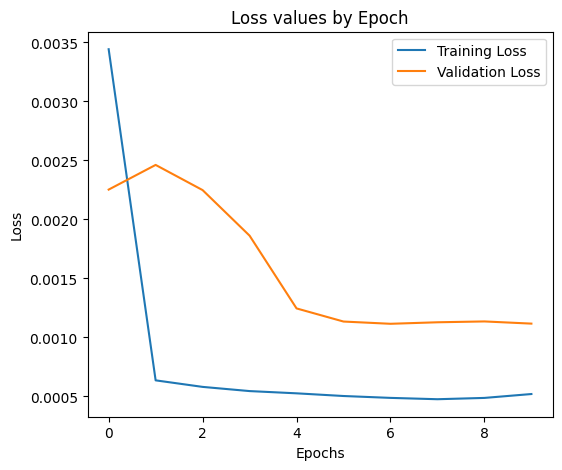

In [38]:
plt.figure(figsize=(6,5))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss values by Epoch")
plt.show()

1. The training loss shows a consistent downward trend, indicating that the model is effectively learning from the training data without significant fluctuations.
2. The validation loss decreases and then stabilizes, suggesting that the model is generalizing well to unseen data. The lack of a significant gap between training and validation loss is a good sign of the model's ability to perform consistently across different datasets.

In [39]:
# Computing reconstruction error for safe URLs
safe_reconstruction = autoencoder.predict(X_train_scaled)
mse_safe = np.mean(np.power(X_train_scaled - safe_reconstruction, 2), axis=1)
print(f"Average reconstruction error for safe URLs: {np.mean(mse_safe)}")

# Computing reconstruction error for malicious URLs
malicious_reconstruction = autoencoder.predict(X_test_scaled)
mse_malicious = np.mean(np.power(X_test_scaled - malicious_reconstruction, 2), axis=1)
print(f"Average reconstruction error for malicious URLs: {np.mean(mse_malicious)}")

13379/13379 [==============================] - 19s 1ms/step
Average reconstruction error for safe URLs: 0.000565753009461783
6972/6972 [==============================] - 10s 1ms/step
Average reconstruction error for malicious URLs: 0.008290500181176455


> Low Error for Safe URLs: The very low average reconstruction error for safe URLs (0.000565753) suggests that the model is highly effective at accurately reconstructing these inputs. This implies that the features of safe URLs are well-learned and closely matched by the model.

> Higher Error for Malicious URLs: The average reconstruction error for malicious URLs is substantially higher (0.008290500) compared to that of safe URLs. This indicates that the model finds these inputs more difficult to reconstruct accurately, which could mean that their feature set is less well-represented in the training data, or they inherently have more variability.

#### Set the threshold for anomaly detection

In [92]:
threshold = np.percentile(mse_safe, 95)  #using 95th percentile of the safe reconstruction error
print(f"Reconstruction error threshold: {threshold}")

Reconstruction error threshold: 0.0021803185153243896


In [93]:
# Flagging new URLs
mse_test = np.mean(np.power(X_test_scaled - malicious_reconstruction, 2), axis=1)
predictions = [1 if mse > threshold else 0 for mse in mse_test]  # 1 = malicious, 0 = safe

In [94]:
recons_df = pd.DataFrame({
    'error': mse_malicious,
    'y_true': y_test
}).reset_index(drop=True)
recons_df.head()

,error,y_true
0,0.000043,1
1,0.008609,1
2,0.009053,1
3,0.007402,1
4,0.006919,1


In [95]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df.head()

,error,y_true,y_pred
0,0.000043,1,False
1,0.008609,1,True
2,0.009053,1,True
3,0.007402,1,True
4,0.006919,1,True


In [96]:
from sklearn.metrics import classification_report, confusion_matrix

In [101]:
#print(classification_report(recons_df['y_true'],recons_df['y_pred'],zero_division=0))

In [102]:
print(classification_report(y_test, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.55      0.71    223088

    accuracy                           0.55    223088
   macro avg       0.50      0.27      0.35    223088
weighted avg       1.00      0.55      0.71    223088



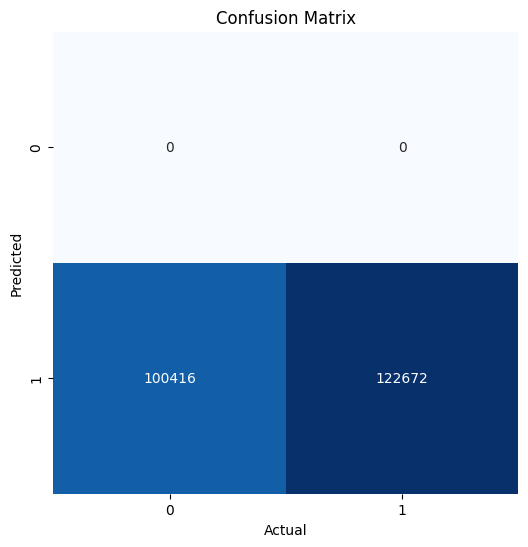

In [105]:
cm = confusion_matrix(recons_df['y_true'],recons_df['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [106]:
# Save the entire autoencoder model to a file
autoencoder.save('autoencoder_model.h5')